# Programmentwurf
In dieser Aufgabe wollen wir Bilder in 6 verschiedene Klassen klassifizieren: "Häuser, Wald, Gletscher, Berge, Wasser, Straße".

## Laden einiger wichtiger Bibliotheken

In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plot
from random import randint
import random

## Laden weiterer Bibliotheken
Soweit benötigt können natürlich weiter Python-Bibliotheken geladen werden. Bitte diese Bibliotheken im unteren Codeblock einfügen.

In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc,confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2
from keras.layers import  GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model

## Dictionary/Map von Klassenname zu Index
Wir bauen ein Mapping zwischen Klassenlabel und Klassenindex

In [3]:
labelMap = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
keyMap = {v: k for k, v in labelMap.items()}
class_labels = list(labelMap.keys())
print(labelMap)
print(keyMap)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


Methode um Bilder aus einem Verzeichnis zu laden

In [14]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    for dirName in os.listdir(directory):
        #print(dirName)
        label = labelMap[dirName]
        
        for image_file in os.listdir(directory+dirName): 
            image = cv2.imread(directory+dirName+r'/'+image_file) 
            im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if image.shape == (150, 150, 3):
                Images.append(im_rgb)
                Labels.append(label)
    
    return Images,Labels

## Laden der Trainingsdaten
Wir laden die Trainingsdaten aus den angegebenen Zip-Dateien

In [26]:
x_train, Y_train = get_images('Data/train/')

## Konvertiere Bilder in Numpy-Arrays

In [27]:
x_train = np.array(x_train) 
Y_train = np.array(Y_train)

In [7]:
print("Shape of Images:",x_train.shape)
print("Shape of Labels:",Y_train.shape)

Shape of Images: (13986, 150, 150, 3)
Shape of Labels: (13986,)


## Zählen der einzelnen Bildklassen
Für einen ersten Eindruck wollen wir wissen, ob die einzelnen Klassen in etwa gleichverteilt sind.

In [8]:
unique_elements, counts_elements = np.unique(Y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2    3    4    5]
 [2190 2263 2387 2495 2270 2381]]


## Plotten der Daten

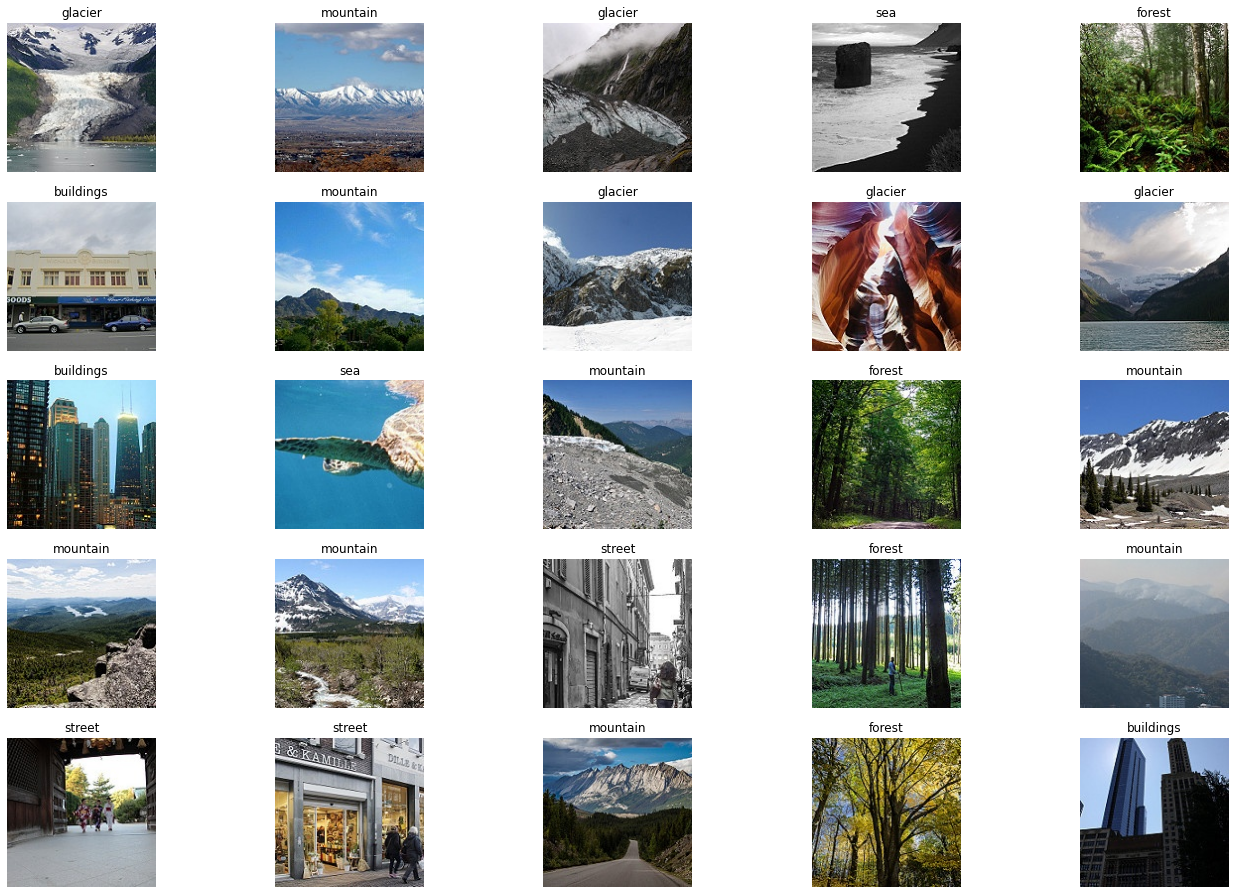

In [9]:
random.seed(1202)
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(x_train))
        ax[i,j].imshow(x_train[rnd_number])
        ax[i,j].set_title(keyMap[Y_train[rnd_number]])
        ax[i,j].axis('off')

## 1.)  Erstellen Sie ein Evaluationsszenario  (5 Punkte)

### 1.1) Erstellen Sie einen stratifizierten Train/Dev-Split (80%-Train / 20%-Dev). 

Zuerst nehmen wir die nach Klassen sortierten Trainingsdaten und Shuffeln sowohl das x_train als auch y_train. Sonst hätte es das Modell nachher denkbar einfach zu erlernen, wann welches Bild kommt, da es einfach die aufsteigende Reihenfolge erlernen könnte. Wichtig ist außerdem, dass x & y mit dem selben seed geshuffelt werden, um zu den Daten auch die richtigen Labels zu erhalten.


In [28]:
x_train, Y_train = shuffle(x_train, Y_train, random_state=0)

Stimmen die Labels noch nach dem Shuffeln?

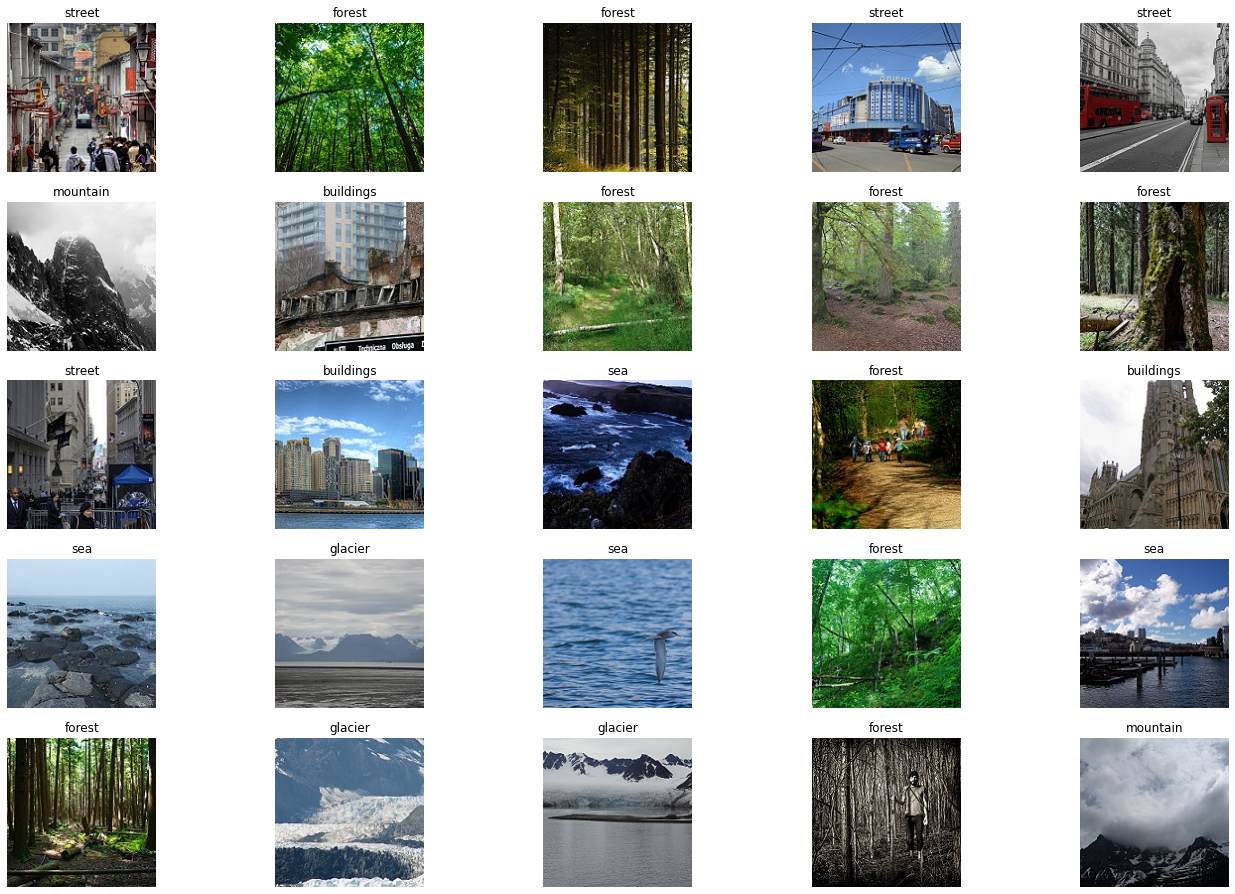

In [16]:
random.seed(1202)
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(x_train))
        ax[i,j].imshow(x_train[rnd_number])
        ax[i,j].set_title(keyMap[Y_train[rnd_number]])
        ax[i,j].axis('off')


Nun können wir einfach die ersten 80% der gemischten Daten als Trainingsdaten verwenden und die restlichen 20% als Dev.

In [29]:
x_train_, x_dev_, y_train_, y_dev_ = train_test_split(x_train, Y_train,
                                                   test_size=0.2,
                                                   stratify=Y_train)

### 1.2) Veranschaulichen Sie, dass die Splits wirklich stratifiziert sind


Sind alle Daten in Train und Dev Unterteilt?

In [25]:
all_data_used = x_train_.shape[0]+x_dev_.shape[0] == x_train.shape[0]
all_data_used

True

Ist die Verteilung noch relativ gleich?

In [19]:
unique_elements, counts_elements_org = np.unique(Y_train, return_counts=True)
unique_elements, counts_elements_train = np.unique(y_train_, return_counts=True)
unique_elements, counts_elements_dev = np.unique(y_dev_, return_counts=True)

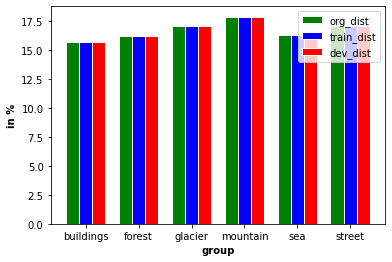

In [ ]:

barWidth = 0.25
bars1 = (counts_elements_org/x_train.shape[0])*100
bars2 = (counts_elements_train/x_train_.shape[0])*100
bars3 = (counts_elements_dev/x_dev_.shape[0])*100
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='var2')
plt.bar(r3, bars3, color='red', width=barWidth, edgecolor='white', label='var3')
 

plt.xlabel('group', fontweight='bold')
plt.ylabel("in %", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], class_labels)
 

plt.legend(labels=["org_dist","train_dist","dev_dist"])
plt.show()


# Kopiert und angepasst von : https://www.python-graph-gallery.com/11-grouped-barplot

Im oberen Graph sieht man, dass die orginale Verteilung der Daten sehr genau der der Traing & Dev- Splits gleicht

### 1.3) Laden Sie die Testdaten (test.zip) und veranschaulichen Sie deren Verteilung

In [11]:
x_test, Y_test = get_images('Data/test/')
x_test = np.array(x_test) 
Y_test = np.array(Y_test)
print("Shape of Images:",x_test.shape)
print("Shape of Labels:",Y_test.shape)

Shape of Images: (2993, 150, 150, 3)
Shape of Labels: (2993,)


Die Verteilung ist wie folgt:

In [ ]:
unique_elements, counts_elements_test = np.unique(Y_test, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2    3    4    5]
 [2190 2263 2387 2495 2270 2381]]


Die Verteilung der Daten aus dem Train und dem Test Ordner im Vergleich:

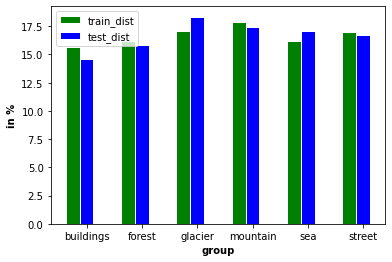

In [ ]:
barWidth = 0.25
bars1 = (counts_elements_org/x_train.shape[0])*100
bars2 = (counts_elements_test/x_test.shape[0])*100

 

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

 

plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='var2')

 

plt.xlabel('group', fontweight='bold')
plt.ylabel("in %", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], class_labels)
 

plt.legend(labels=["train_dist","test_dist"])
plt.show()

# Kopiert und angepasst von : https://www.python-graph-gallery.com/11-grouped-barplot

##  2.) Trainieren Sie eine Baseline  (10 Punkte)

### 2.1) Trainieren Sie (auf den Trainingsdaten) einen Naive Bayes-Klassifikator, welcher alle 6 Bildklassen erkennt. 

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_reshaped = x_train_.reshape(x_train_.shape[0], 150*150*3)
X_train_scaled = scaler.fit_transform(X_train_reshaped) #Skalierung der Pixelwerte 

X_dev_reshaped = x_dev_.reshape(x_dev_.shape[0], 150*150*3)
X_dev_scaled = scaler.fit_transform(X_dev_reshaped) 

Ausprobieren mehrer NB Implementierungen. 

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB


clf1 = GaussianNB()
clf2 = BernoulliNB()
clf3 = MultinomialNB()

clf1.fit(X_train_scaled, y_train_)
clf2.fit(X_train_scaled, y_train_)
clf3.fit(X_train_scaled, y_train_)


y_pred1 = clf1.predict(X_dev_scaled)
y_pred2 = clf2.predict(X_dev_scaled)
y_pred3 = clf3.predict(X_dev_scaled)


acc1 = accuracy_score(y_dev_, y_pred1)
acc2 = accuracy_score(y_dev_, y_pred2)
acc3 = accuracy_score(y_dev_, y_pred3)
print("Accuracy for GaussianNB:", acc1)
print("Accuracy for BernoulliNB:", acc2)
print("Accuracy for MultinomialNB:", acc3)

Accuracy for GaussianNB: 0.4749821300929235
Accuracy for BernoulliNB: 0.36812008577555394
Accuracy for MultinomialNB: 0.4410293066476054


Die Accuracy ist bei allen drei implementierungen < 50%. Auch eine denkbare Hyperparameteroptimierung wird hier wahrscheinlich keine Wunder mehr bewirken. 

### 2.2) Evaluieren Sie diesen Klassifikator auf dem Test-Set (Accuracy)


In [ ]:
X_test_reshaped = x_test.reshape(x_test.shape[0], 150*150*3)
X_test_scaled = scaler.transform(X_test_reshaped)
y_pred = clf1.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, y_pred)
precission = precision_score(Y_test, y_pred,average='macro')
recall = recall_score(Y_test, y_pred,average='macro')
f1_score = f1_score(Y_test, y_pred,average='macro')
print("Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1-Score: {:.3f}".format(accuracy, precission, recall, f1_score))

Accuracy: 0.469, Precision: 0.462, Recall: 0.466, F1-Score: 0.445


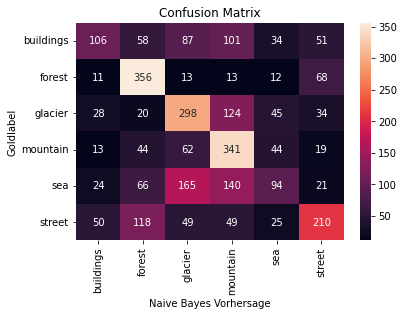

In [ ]:
conf_matrix = confusion_matrix(Y_test, y_pred)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Naive Bayes Vorhersage')
plt.ylabel('Goldlabel')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels,rotation='vertical')
ax.yaxis.set_ticklabels(class_labels,rotation='horizontal')
plt.show()

Naive Bayes hat hier bei fast allen Klassen Probleme diese auseinanderzuhalten. Auffällig wenig wird "sea" & "building" erkannt. Das größte Problem bei späteren Implementierung wird sein, Berg und Glätscher auseinander zu halten. Dies ist hier nicht (übermäßig) der Fall.

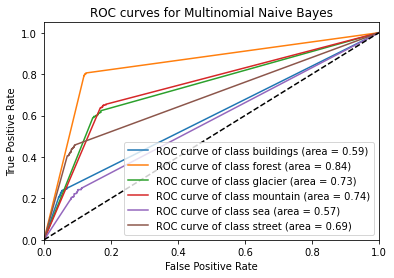

In [ ]:
# -- Bitte ignorieren -- 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
y_pred_prob = clf1.predict_proba(scaler.transform(x_dev_.reshape(x_dev_.shape[0], 150*150*3)))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_dev_, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for Multinomial Naive Bayes')
plt.legend(loc="lower right")
plt.show()

## 3.)  Trainieren Sie ein Neuronales Netz zur Bilderkennung (20 Punke)

### 3.1) Entwickeln Sie ein mehrschichtiges CNN-Model mit Dropout


In [4]:

model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  


model.add(Flatten())


model.add(Dense(len(class_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [114]:
from keras.callbacks import ProgbarLogger
from sklearn.preprocessing import StandardScaler

logger = ProgbarLogger()
scaler = StandardScaler()

x_train_ = scaler.fit_transform(x_train_.reshape(x_train_.shape[0], -1))
x_train_ = x_train_.reshape(x_train_.shape[0], 150, 150, 3)
y_train_ = to_categorical(y_train_)

x_dev_ = scaler.fit_transform(x_dev_.reshape(x_dev_.shape[0], -1))
x_dev_ = x_dev_.reshape(x_dev_.shape[0], 150, 150, 3)
y_dev_ = to_categorical(y_dev_)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
train_data = model.fit(x_train_, y_train_, epochs=25, batch_size=32, validation_data=(x_dev_, y_dev_), callbacks=[#tensorboard,
early_stopping])

Epoch 1/25
350/350 [==============================] - 301s 852ms/step - loss: 1.0002 - accuracy: 0.6345 - val_loss: 0.8119 - val_accuracy: 0.6869
Epoch 2/25
350/350 [==============================] - 310s 887ms/step - loss: 0.6617 - accuracy: 0.7638 - val_loss: 0.5879 - val_accuracy: 0.7966
Epoch 3/25
350/350 [==============================] - 311s 888ms/step - loss: 0.5306 - accuracy: 0.8124 - val_loss: 0.5353 - val_accuracy: 0.8131
Epoch 4/25
350/350 [==============================] - 315s 900ms/step - loss: 0.4543 - accuracy: 0.8376 - val_loss: 0.5891 - val_accuracy: 0.7974
Epoch 5/25
350/350 [==============================] - 286s 818ms/step - loss: 0.3748 - accuracy: 0.8670 - val_loss: 0.6246 - val_accuracy: 0.7802
Epoch 6/25
350/350 [==============================] - 288s 822ms/step - loss: 0.3215 - accuracy: 0.8818 - val_loss: 0.5734 - val_accuracy: 0.8084
Epoch 7/25
350/350 [==============================] - 302s 862ms/step - loss: 0.2695 - accuracy: 0.9029 - val_loss: 0.5794 -

In [25]:
import time
model.save('saved_models/NormalCNN.h5', include_optimizer=True)

### 3.2) Entwickeln Sie ein beliebiges neuronales Modell (z.B. Residual-connections, mehr/weniger Schichten als 3.1 etc)


Finetuning von Inceptionv3 (https://arxiv.org/abs/1512.00567v3)
Dazu werden die letzten 3 Layer zum training freigegeben und ein kleines neuronales Netz mit Dropout hinten dran gehängt und auf die spezifische Klassifikationsaufgabe trainiert. Zudem wird mit Early Stopping nach 5 Epochen "stagnierenden" val loss der Trainingsvorgang abgebrochen. 
Dies ist auch schon im obrigen CNN implementiert. 

In [10]:
from keras.applications import InceptionV3
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

input_shape = (150, 150, 3)

base_model = InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_shape=input_shape)

for layer in base_model.layers[-3:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=50,validation_data=(x_dev_, y_dev_),
callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')])


In [ ]:
model.save('path/to/save/Inceptionv3_Durchlauf1.h5', include_optimizer=True)

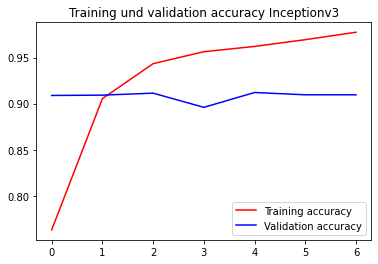

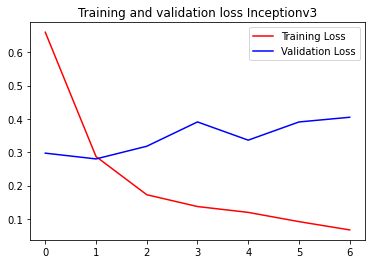

In [ ]:
acc = train_data.history['accuracy']
val_acc = train_data.history['val_accuracy']
loss = train_data.history['loss']
val_loss = train_data.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training und validation accuracy Inceptionv3')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss Inceptionv3')
plt.legend()

Da das Training hier doch recht lange gedauert hat, probiere ich hier ein etwas parameterärmeres Model zu verwenden und das Finetuning auf das fully-connected nach dem Base Model zu beschränken. Die val-accuracy verschlechtert sich dadurch etwas, jedoch beschleunigt dies die Trainingsdauer und unvorhergesehen Crashs des Kernels gibt es auch nicht mehr. 

In [ ]:

input_shape = (150, 150, 3)

base_model = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=50,validation_data=(x_dev_, y_dev_),
callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')])

Epoch 1/50
350/350 [==============================] - 217s 605ms/step - loss: 0.7415 - accuracy: 0.7345 - val_loss: 0.3373 - val_accuracy: 0.8853
Epoch 2/50
350/350 [==============================] - 175s 500ms/step - loss: 0.4160 - accuracy: 0.8517 - val_loss: 0.3134 - val_accuracy: 0.8921
Epoch 3/50
350/350 [==============================] - 176s 504ms/step - loss: 0.3506 - accuracy: 0.8725 - val_loss: 0.3057 - val_accuracy: 0.8914
Epoch 4/50
350/350 [==============================] - 170s 486ms/step - loss: 0.3178 - accuracy: 0.8844 - val_loss: 0.2989 - val_accuracy: 0.8971
Epoch 5/50
350/350 [==============================] - 165s 471ms/step - loss: 0.3032 - accuracy: 0.8910 - val_loss: 0.2945 - val_accuracy: 0.8942
Epoch 6/50
350/350 [==============================] - 167s 478ms/step - loss: 0.2672 - accuracy: 0.9021 - val_loss: 0.2899 - val_accuracy: 0.8992
Epoch 7/50
350/350 [==============================] - 161s 461ms/step - loss: 0.2533 - accuracy: 0.9056 - val_loss: 0.2907 -

In [ ]:
model.save('path/to/save/MobileNetv2_Durchlauf1.h5', include_optimizer=True)

### 3.3) Visualisieren Sie die Architekturen der beiden Modelle


In [7]:
from keras.utils import plot_model

CNN:

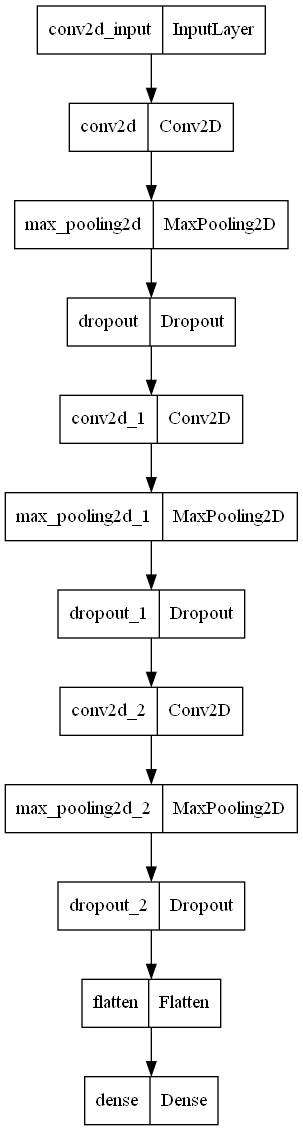

In [6]:
plot_model(model)

Inceptionv3:

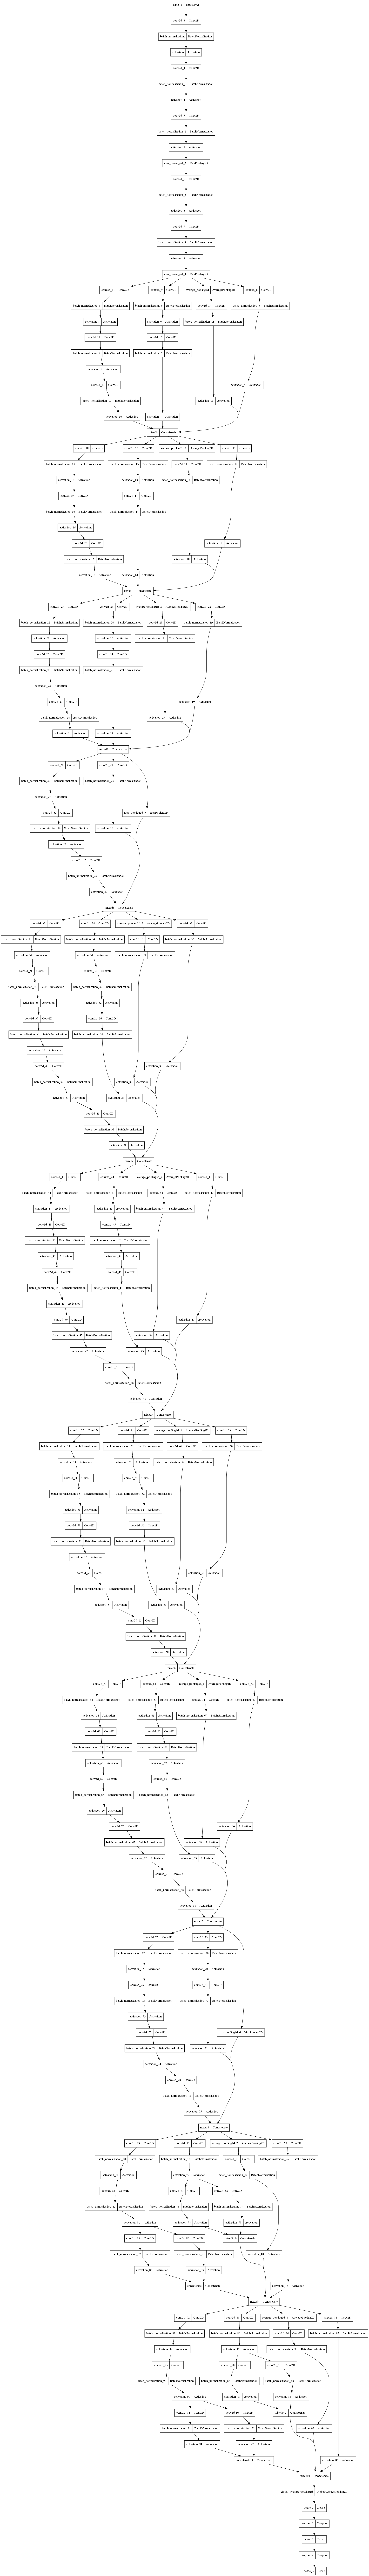

In [9]:
plot_model(model)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

### 3.4) Plotten Sie für beide Modelle den Loss und die Accuracy über 10 Epochen
Normales CNN:

Da die Validation Accuracy (blau) langsam stagniert und die Training Accuracy weiter ansteigt ist eventuell ein leichtes Overfitting hier schon erkennbar. 

Dennoch steigt die validation accuracy manchmal noch etwas an z.B. Epoche 10, jedoch verbessert sich ab Epoche 7 nurnoch die Trainings Accuracy stetig und die Validation Accuracy scheint bei etwa 75 % hoch und runter zu springen. Ähnliches sieht man auch beim Loss-Wert, der ab einer bestimmten Epoche nur beim Trainingsdatensatz weiter abnimmt. Man sollt also dem overfitting mit verschiedenen Techniken entgegenwirken (z.B. lr mit grid/random-search, mehr/größere Dropoutschichten, ...) und dann schauen, ob sich ein längeres Training hier lohnt.


Grafik aus Tensorboard

In [ ]:
from IPython.display import HTML
HTML('<img src="pics\FirstCNNTensorboardAccuracy.png">')

In [ ]:
from IPython.display import HTML
HTML('<img src="pics\FirstCNNTensorboardLoss.png">')

MobileNet using matplotlib

Finetuning of MobileNet:

Da hier durch Finetuning schon eine bestehende Baseline genutzt wird, und in der ersten Epoche des Trainings dadurch eine bereits sehr gute Trainingsaccuracy erreicht werden konnte starten die validation Accuracy bei einem recht hohen Wert. Eine Verbesserung wie bei CNN ist hier deshalb kaum ersichtlich und die validation accuracy bleibt größtenteils gleich (gut) während die Trainingsaccuracy steigt. Dies ist ein deutlichen anzeichen von Overfitting, was die Vermutung nahe legt, dass die Gewichte die im nachgeschalteten Netz erlernt werden, nicht gut genug generalisieren können. Im leichten Maße steigt in den ersten Epochen noch die Accuracy (& der Loss sinkt), jedoch würden mehr als 10 Epochen hier höchstwahrscheinlich keine Verbesserung bringen. 

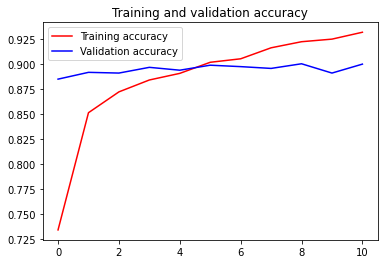

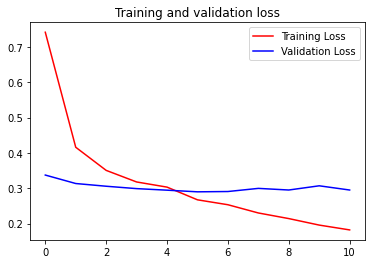

In [ ]:
acc = train_data.history['accuracy']
val_acc = train_data.history['val_accuracy']
loss = train_data.history['loss']
val_loss = train_data.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training und validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

## 4.) Evaluieren und interpretieren Sie das Netzwerk auf den Test-Daten (20)


### 4.1) Vergleichen Sie die Performanz beider neuronalen Modelle und die baseline. Welches Modell würden Sie produktiv einsetzen? Alle weiteren Analysen erfolgen auf dem, Ihrer Meinung nach, besseren (neuronalen) Modell


Die Baseline, also Naive Bayes kann man wohl für diese Klassifikationsaufgabe nicht verwenden. Der Grund dafür ist die niedrige Accuracy auf den Testdaten. Auch die anderen Kennzahlen sehen wenig vielversprechend aus.

Das Basis CNN performt schon deutlich besser, hat jedoch mit einer validation Accuracy von nicht über 80% ebenfalls probleme, die Klassen richtig zu erkennen. 

Das Netz welches mit finetuning auf MobileNetv2/Inceptionv3 aufsetzt, erreicht vergleichsweise hohe Genauigkeiten auf den Trainings und Validierungsdaten. Deshalb wäre eine weitere Untersuchung dieser sinnvoll. 

### 4.2) Schätzen Sie die Genauigkeit/Accuracy Ihrer Methode für jede Klasse separat, sowie für alle Klasse


In [5]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_test, Y_test = get_images('Data/test/')
x_test = np.array(x_test) 
Y_test = np.array(Y_test)
x_test = scaler.fit_transform(x_test.reshape(x_test.shape[0], -1))
x_test = x_test.reshape(x_test.shape[0], 150, 150, 3)
model = load_model('saved_models/Inceptionv3_Durchlauf1.h5')
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_val = Y_test
print(classification_report(y_val, y_pred, target_names=class_labels,digits = 4))

94/94 [==============================] - 74s 768ms/step
              precision    recall  f1-score   support

   buildings     0.9373    0.8902    0.9131       437
      forest     0.9831    0.9831    0.9831       473
     glacier     0.8622    0.8434    0.8527       549
    mountain     0.8533    0.8566    0.8550       523
         sea     0.9336    0.9373    0.9354       510
      street     0.9002    0.9541    0.9264       501

    accuracy                         0.9091      2993
   macro avg     0.9116    0.9108    0.9109      2993
weighted avg     0.9093    0.9091    0.9089      2993



Die Labels auf den Konfusionsmatrizen stimmen hier nicht. Eine erneute Durchführung der Evaluierung würde aber viel Rechenezeit in Anspruch nehmen. Die kommentare im Code und die Namen der geladene Modelle signalisieren, welches Modell getestet wird.

              precision    recall  f1-score      support
buildings      0.937349  0.890160  0.913146   437.000000
forest         0.983087  0.983087  0.983087   473.000000
glacier        0.862197  0.843352  0.852670   549.000000
mountain       0.853333  0.856597  0.854962   523.000000
sea            0.933594  0.937255  0.935421   510.000000
street         0.900188  0.954092  0.926357   501.000000
accuracy       0.909121  0.909121  0.909121     0.909121
macro avg      0.911625  0.910757  0.910940  2993.000000
weighted avg   0.909251  0.909121  0.908946  2993.000000


<AxesSubplot:>

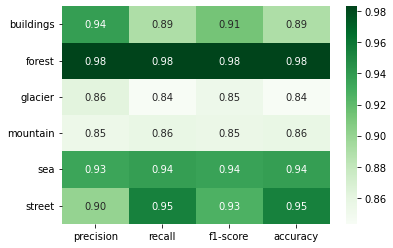

In [6]:
# --Inceptionv3 --
from copy import deepcopy
classification_rep = classification_report(y_val, y_pred, target_names=class_labels,digits = 4,output_dict=True)
report_df = pd.DataFrame(classification_rep).transpose()
cm = confusion_matrix(y_val, y_pred)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
class_accuracies = np.append(class_accuracies,[0,0,0])
cl = deepcopy(class_labels)
print(report_df)

report_df["accuracy"] = class_accuracies
report_df = report_df[report_df.index.isin(cl)]

sns.heatmap(report_df[["precision", "recall", "f1-score","accuracy"]], annot=True, cmap='Greens', fmt='.2f', xticklabels=["precision", "recall", "f1-score","accuracy"], yticklabels=cl)

In [8]:
#--MobileNetv2--
model = load_model('saved_models/MobileNetv2_Durchlauf1.h5')
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_val = Y_test

print(classification_report(y_val, y_pred, target_names=class_labels,digits = 4))

94/94 [==============================] - 46s 465ms/step
              precision    recall  f1-score   support

   buildings     0.9260    0.9451    0.9354       437
      forest     0.9811    0.9873    0.9842       473
     glacier     0.8301    0.8634    0.8464       549
    mountain     0.8442    0.8394    0.8418       523
         sea     0.9446    0.9020    0.9228       510
      street     0.9473    0.9321    0.9396       501

    accuracy                         0.9088      2993
   macro avg     0.9122    0.9115    0.9117      2993
weighted avg     0.9096    0.9088    0.9090      2993



              precision    recall  f1-score      support
buildings      0.926009  0.945080  0.935447   437.000000
forest         0.981092  0.987315  0.984194   473.000000
glacier        0.830123  0.863388  0.846429   549.000000
mountain       0.844231  0.839388  0.841802   523.000000
sea            0.944559  0.901961  0.922768   510.000000
street         0.947262  0.932136  0.939638   501.000000
accuracy       0.908787  0.908787  0.908787     0.908787
macro avg      0.912212  0.911545  0.911713  2993.000000
weighted avg   0.909554  0.908787  0.909000  2993.000000


<AxesSubplot:>

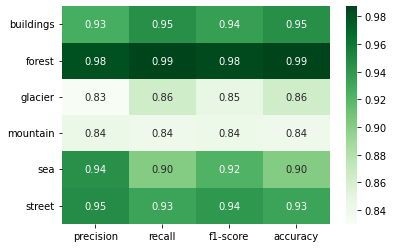

In [9]:
classification_rep = classification_report(y_val, y_pred, target_names=class_labels,digits = 4,output_dict=True)
report_df = pd.DataFrame(classification_rep).transpose()
cm = confusion_matrix(y_val, y_pred)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
class_accuracies = np.append(class_accuracies,[0,0,0])
cl = deepcopy(class_labels)
print(report_df)

report_df["accuracy"] = class_accuracies
report_df = report_df[report_df.index.isin(cl)]

sns.heatmap(report_df[["precision", "recall", "f1-score","accuracy"]], annot=True, cmap='Greens', fmt='.2f', xticklabels=["precision", "recall", "f1-score","accuracy"], yticklabels=cl)

In [11]:
# -- NormalCNN --
model = load_model('saved_models/NormalCNN.h5')
# Make predictions on the validation data
y_pred = model.predict(x_test)
# Convert the predictions from one-hot encoded format to class labels
y_pred = np.argmax(y_pred, axis=1)
y_val = Y_test
classification_rep = classification_report(y_val, y_pred, target_names=class_labels,digits = 4)



94/94 [==============================] - 31s 320ms/step


              precision    recall  f1-score      support
buildings      0.804455  0.743707  0.772889   437.000000
forest         0.883365  0.976744  0.927711   473.000000
glacier        0.787934  0.785064  0.786496   549.000000
mountain       0.769797  0.799235  0.784240   523.000000
sea            0.818725  0.805882  0.812253   510.000000
street         0.835443  0.790419  0.812308   501.000000
accuracy       0.816238  0.816238  0.816238     0.816238
macro avg      0.816620  0.816842  0.815983  2993.000000
weighted avg   0.815458  0.816238  0.815142  2993.000000


<AxesSubplot:>

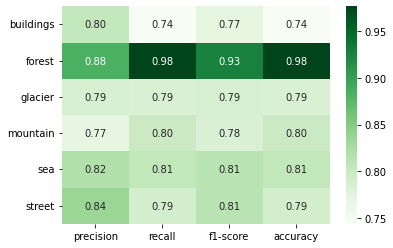

In [12]:
classification_rep = classification_report(y_val, y_pred, target_names=class_labels,digits = 4,output_dict=True)
report_df = pd.DataFrame(classification_rep).transpose()
cm = confusion_matrix(y_val, y_pred)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
class_accuracies = np.append(class_accuracies,[0,0,0])
cl = deepcopy(class_labels)
print(report_df)

report_df["accuracy"] = class_accuracies
report_df = report_df[report_df.index.isin(cl)]

sns.heatmap(report_df[["precision", "recall", "f1-score","accuracy"]], annot=True, cmap='Greens', fmt='.2f', xticklabels=["precision", "recall", "f1-score","accuracy"], yticklabels=cl)

### 4.3) Erzeugen Sie eine Confusion Matrix 


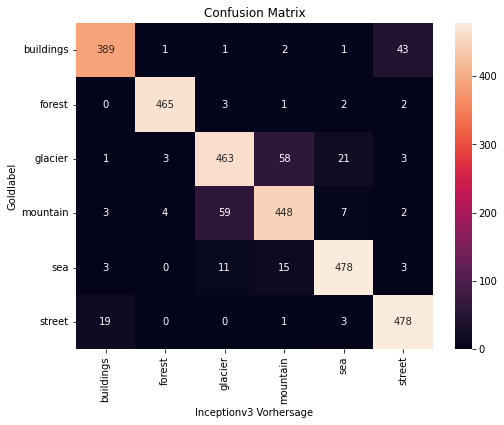

In [7]:
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Inceptionv3 Vorhersage')
plt.ylabel('Goldlabel')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels,rotation='vertical')
ax.yaxis.set_ticklabels(class_labels,rotation='horizontal')
plt.show()

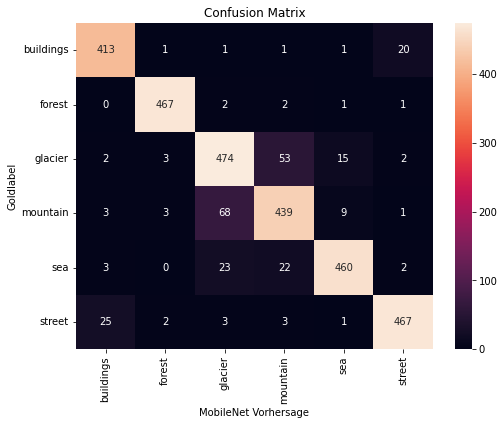

In [10]:

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('MobileNet Vorhersage')
plt.ylabel('Goldlabel')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels,rotation='vertical')
ax.yaxis.set_ticklabels(class_labels,rotation='horizontal')
plt.show()

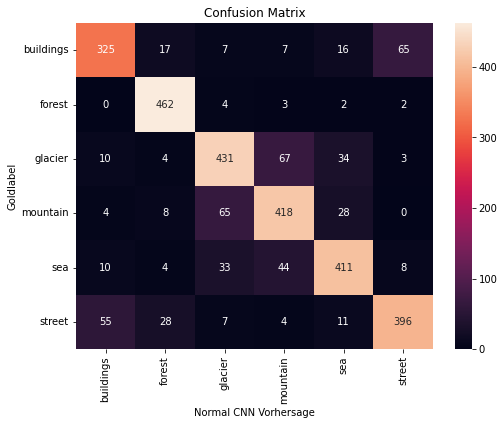

In [13]:

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Normal CNN Vorhersage')
plt.ylabel('Goldlabel')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels,rotation='vertical')
ax.yaxis.set_ticklabels(class_labels,rotation='horizontal')
plt.show()

### 4.4) Interpretation der Confusion-Matrix. Welche Klasse ist am schwersten zu klassifizieren und mit welchen Klassen wird sie oft „verwechselt“


Es ist scheinbar super schwierig für alle Modelle Berg & Glätscher auseinander zu halten. Dies ist aber selbst schwierig für das menschliche Auge zu unterscheiden in diesem spezifischen Datensatz. Buildings & Street kommt direkt danach, diese Bilder sind für die Modelle auch schwer zu klassifizieren. Recht eindeutig hingegen ist etwa Wald. 

## 5.) Geben Sie für ein ausgewähltes Testbild (example-150.png) die Klassenwahrscheinlichkeiten aus (5 Punkte)


### 5.1) Wenden Sie Ihr Modell auf das Testbild (example-150.png) an.
Plotten Sie das ausgewählte Bild und nennen Sie die 6 Wahrscheinlichkeiten der einzelnen Bildklassen


In [18]:
image = cv2.imread("pics/glacier/150.jpg") 
im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imshow('image',image)
cv2.waitKey(0)

-1

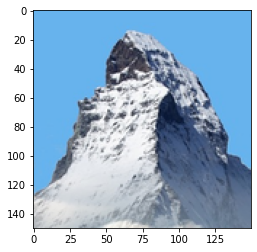

In [19]:
plt.imshow(im_rgb)
plt.show()

In [20]:
scaler = StandardScaler()
im_rgb = scaler.fit_transform(im_rgb.reshape(im_rgb.shape[0], -1))
im_rgb = im_rgb.reshape(1, 150, 150, 3)
im_rgb

array([[[[-0.472933  , -0.32322059,  0.44766983],
         [-0.43466675, -0.1673015 ,  0.41375731],
         [-0.41785479, -0.15421775,  0.37514803],
         ...,
         [ 0.30626671,  0.60089402,  0.61982284],
         [ 0.30226345,  0.58684082,  0.60914432],
         [ 0.29918212,  0.5823261 ,  0.60459208]],

        [[-0.472933  , -0.32322059,  0.44766983],
         [-0.43466675, -0.1673015 ,  0.41375731],
         [-0.41785479, -0.15421775,  0.37514803],
         ...,
         [ 0.30626671,  0.60089402,  0.61982284],
         [ 0.30226345,  0.58684082,  0.60914432],
         [ 0.29918212,  0.5823261 ,  0.60459208]],

        [[-0.472933  , -0.32322059,  0.44766983],
         [-0.43466675, -0.1673015 ,  0.41375731],
         [-0.41785479, -0.15421775,  0.37514803],
         ...,
         [ 0.30626671,  0.60089402,  0.61982284],
         [ 0.30226345,  0.58684082,  0.60914432],
         [ 0.29918212,  0.5823261 ,  0.60459208]],

        ...,

        [[ 1.69839461, -0.21328161, -3

In [23]:
model = load_model('saved_models/NormalCNN.h5')
predictions = model.predict(im_rgb)
dict = {}
for i,ele in enumerate(class_labels):
    dict[ele] = str(round((predictions[0][i]*100),3))+" %"
dict

1/1 [==============================] - 0s 91ms/step


{'buildings': '85.151 %',
 'forest': '0.013 %',
 'glacier': '0.17 %',
 'mountain': '0.969 %',
 'sea': '10.578 %',
 'street': '3.119 %'}

## 6.) Trainieren Sie für jede der beiden neuronalen Architekturen mehrere Modelle (20 Punkte)



### 6.1) Definieren Sie (mindestens) 5 random seeds 


In [21]:
seeds = []
for i in range(0,5):
    seeds.append(random.randint(0,(2**32-1)))
seeds

[3397748923, 943827110, 3497719044, 187570877, 3277143702]

In [22]:
seeds = [2005225354, 450796038, 3416329015, 585690048, 1797869589]

### 6.2) Trainieren Sie für jeden random seed die Modelle (3.1 und 3.2)


In [23]:
scaler = StandardScaler()
x_test, Y_test = get_images('Data/test/')
x_test = np.array(x_test) 
Y_test = np.array(Y_test)
x_test = scaler.fit_transform(x_test.reshape(x_test.shape[0], -1))
x_test = x_test.reshape(x_test.shape[0], 150, 150, 3)

In [30]:
scaler = StandardScaler()

x_train_ = scaler.fit_transform(x_train_.reshape(x_train_.shape[0], -1))
x_train_ = x_train_.reshape(x_train_.shape[0], 150, 150, 3)
y_train_ = to_categorical(y_train_)

x_dev_ = scaler.fit_transform(x_dev_.reshape(x_dev_.shape[0], -1))
x_dev_ = x_dev_.reshape(x_dev_.shape[0], 150, 150, 3)
y_dev_ = to_categorical(y_dev_)

In [38]:
import tensorflow as tf 
def train_mobileNet_with_seed(seed:int):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    input_shape = (150, 150, 3)

    base_model = MobileNetV2(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    predictions = Dense(len(class_labels), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=2,validation_data=(x_dev_, y_dev_),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')],shuffle=False)

    return model, train_data

In [47]:
from keras.applications import InceptionV3
def train_inception_with_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

    input_shape = (150, 150, 3)

    base_model = InceptionV3(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape
                            )

    for layer in base_model.layers[-3:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    predictions = Dense(len(class_labels), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=2,validation_data=(x_dev_, y_dev_),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')],
    shuffle=False)
    return model, train_data


In [ ]:
for seed in seeds:
    model, train_data = train_mobileNet_with_seed(seed)
    model.save(f"saved_models/seed_models/MobileNetv2_seed_{seed}.h5", include_optimizer=True)
    print(train_data.history['val_accuracy'][-1])
    acc_dict["MobileNetv2_seed_{seed}"] = train_data.history['val_accuracy'][-1]


In [48]:
acc_dict = {}
for seed in seeds:
    model, train_data = train_inception_with_seed(seed)
    model.save(f"saved_models/seed_models/Inceptionv3_seed_{seed}.h5", include_optimizer=True)
    print(train_data.history['val_accuracy'][-1])
    acc_dict["Inceptionv3_seed_{seed}"] = train_data.history['val_accuracy'][-1]


Epoch 1/2
350/350 [==============================] - 1594s 5s/step - loss: 0.6341 - accuracy: 0.7686 - val_loss: 0.3522 - val_accuracy: 0.8863
Epoch 2/2
350/350 [==============================] - 1531s 4s/step - loss: 0.2207 - accuracy: 0.9256 - val_loss: 0.3097 - val_accuracy: 0.9089
0.9088634848594666
Epoch 1/2
350/350 [==============================] - 1567s 4s/step - loss: 0.6301 - accuracy: 0.7749 - val_loss: 0.3874 - val_accuracy: 0.8806
Epoch 2/2
350/350 [==============================] - 1496s 4s/step - loss: 0.2164 - accuracy: 0.9309 - val_loss: 0.3278 - val_accuracy: 0.9139
0.9138670563697815
Epoch 1/2
350/350 [==============================] - 1568s 4s/step - loss: 0.6367 - accuracy: 0.7640 - val_loss: 0.3613 - val_accuracy: 0.8853
Epoch 2/2
350/350 [==============================] - 1500s 4s/step - loss: 0.2206 - accuracy: 0.9257 - val_loss: 0.3499 - val_accuracy: 0.9010
0.9010007381439209
Epoch 1/2
350/350 [==============================] - 1642s 5s/step - loss: 0.6232 - a

In [50]:
import pickle
with open("saved_models/seed_models/pickle_data/accuracy_dict_train_incep.pkl", "wb") as f:
    pickle.dump(acc_dict, f)

### 6.3) Evaluieren Sie alle Modelle auf den Testdaten 


In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_test, Y_test = get_images('Data/test/')
x_test = np.array(x_test) 
Y_test = np.array(Y_test)
x_test = scaler.fit_transform(x_test.reshape(x_test.shape[0], -1))
x_test = x_test.reshape(x_test.shape[0], 150, 150, 3)

In [16]:
import os
from fnmatch import fnmatch
from sklearn.metrics import accuracy_score
folder_path = 'saved_models/seed_models'
pattern = '*MobileNet*'
pattern2 = '*Inceptionv3*'
accuracy_dict = {}
accuracy_dict["MobileNet"] = []
accuracy_dict["Inceptionv3"] = []
for file_name in os.listdir(folder_path):
    if fnmatch(file_name, pattern) or fnmatch(file_name, pattern2):
        file_path = os.path.join(folder_path, file_name)
        model = load_model(file_path)
        y_pred = model.predict(x_test)
        y_pred = np.argmax(y_pred, axis=1)
        test_acc = accuracy_score(Y_test, y_pred)
        if fnmatch(file_name, pattern):
            accuracy_dict["MobileNet"].append(test_acc)
        if fnmatch(file_name, pattern2):
            accuracy_dict["Inceptionv3"].append(test_acc)
        print(test_acc)
# Die ersten 5 -> Inception, dann MobileNet

94/94 [==============================] - 56s 573ms/step
0.9017707985299032
94/94 [==============================] - 54s 558ms/step
0.9061142666221182
94/94 [==============================] - 57s 579ms/step
0.9024390243902439
94/94 [==============================] - 70s 723ms/step
0.9097895088539927
94/94 [==============================] - 61s 624ms/step
0.9081189442031407
94/94 [==============================] - 32s 329ms/step
0.8757099899766121
94/94 [==============================] - 35s 350ms/step
0.8787170063481456
94/94 [==============================] - 32s 327ms/step
0.8800534580688273
94/94 [==============================] - 32s 326ms/step
0.879051119278316
94/94 [==============================] - 42s 430ms/step
0.8723688606749082


In [17]:
accuracy_dict

{'MobileNet': [0.8757099899766121,
  0.8787170063481456,
  0.8800534580688273,
  0.879051119278316,
  0.8723688606749082],
 'Inceptionv3': [0.9017707985299032,
  0.9061142666221182,
  0.9024390243902439,
  0.9097895088539927,
  0.9081189442031407]}

### 6.4) Plotten Sie die Verteilungen (Accuracy) der beiden Modelle als Boxplot oder Violin plot


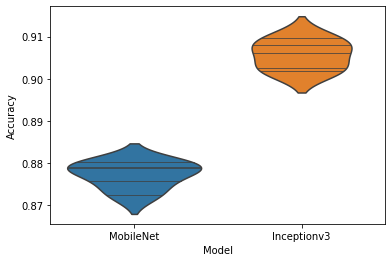

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame.from_dict(accuracy_dict)
sns.violinplot(data=df, inner="stick")
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

### 6.5) Interpretieren Sie die Ergebnisse. Welches der beiden Modelle ist besser?


Das finegetunte Inceptionv3 liefert auf den Testdaten für jeden Seed eine bessere Accuracy als es MobileNet tut. Die Verteilung der beiden Modelle bzw. der Raum in dem sich deren Genauigkeit bewegt ist über ihre 5 Seeds relativ ähnlich, jedoch gibt es beim Mittelwert der Genaugikeit einen gut sichbaren Unterschied. Das finegetunte Inceptionv3 Netzwerk ist also von allen getesten Architekturen die (mit Abstand) beste.

## 7.) Bauen Sie ein (einfaches) Ensemble  (20 Punkte)


### 7.1 Implementieren Sie ein einfaches majority-voting Ensemble (Empfehlung nehmen Sie die Modelle aus 6)

In [19]:
from fnmatch import fnmatch
folder_path = 'saved_models/seed_models'
pattern = '*MobileNet*'
pattern2 = '*Inceptionv3*'
models = []
for file_name in os.listdir(folder_path):
    if fnmatch(file_name, pattern) or fnmatch(file_name, pattern2):
        file_path = os.path.join(folder_path, file_name)
        model = load_model(file_path)
        models.append(model)


In [20]:
def ensemble_predict(models, test_data):
    predictions = []
    for model in models:
        predictions.append(model.predict(test_data))
    return predictions


In [21]:
ensemble_predictions = ensemble_predict(models, x_test)

94/94 [==============================] - 37s 373ms/step


In [22]:

def majority_voting_ensemble(predictions):
    ensemble_predictions = []
    for i in range(len(predictions[0])):
        ensemble_predictions.append(np.argmax(np.bincount([np.argmax(pred[i]) for pred in predictions])))
    return ensemble_predictions

ensemble_predictions = majority_voting_ensemble(ensemble_predictions)

### 7.2) Evaluieren Sie den Ensemble-Klassifikator auf dem Test-set

In [23]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, ensemble_predictions)
print("Ensemble accuracy:", accuracy)

Ensemble accuracy: 0.9208152355496158


Nur Inception Modelle:

In [25]:
from fnmatch import fnmatch
folder_path = 'saved_models/seed_models'
pattern2 = '*Inceptionv3*'
models = []
for file_name in os.listdir(folder_path):
    if fnmatch(file_name, pattern2):
        file_path = os.path.join(folder_path, file_name)
        model = load_model(file_path)
        models.append(model)
ensemble_predictions = ensemble_predict(models, x_test)
ensemble_predictions = majority_voting_ensemble(ensemble_predictions)
accuracy = accuracy_score(Y_test, ensemble_predictions)
print("Ensemble accuracy:", accuracy)

94/94 [==============================] - 83s 853ms/step
Ensemble accuracy: 0.9234881389909789


In [76]:
ensemble_predictions = ensemble_predict(models, x_train_)
ensemble_predictions = np.array(ensemble_predictions)
ensemble_predictions = ensemble_predictions.T

350/350 [==============================] - 255s 729ms/step


In [ ]:
ensemble_predictions_test = ensemble_predict(models, x_test)
ensemble_predictions_test = np.array(ensemble_predictions_test)
ensemble_predictions_test = ensemble_predictions_test.T
predictions = model.predict(ensemble_predictions_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(Y_test, predictions)
print("Stacking ensemble accuracy:", accuracy)

### 7.3 Wie ist die Performanz des Ensembles im Vergleich zu den einzelnen Modellen? Welches Modell würden Sie am Ende einsetzen? Begründen Sie Ihre Antwort.

Das Ensemble schafft es die Performance nochmals zu verbessern, sodass die Testaccuracy mit beiden Modellen bei über 92% liegt. Wenn man nun nur die Inception Modelle berücksichtigt, schafft man es sogar auf ca 92,35% Genaugikeit auf den Testdaten. Wenn performance keine Rolle spielt, würde ich uneingeschränkt das Ensemble empfehlen da es die beste Genauigkeit liefert. 

## 8.) Bitte schätzen Sie den benötigten Zeitaufwand für die Übung (optional)

Für die Übungen habe ich ca. 30 Stunden benötigt. Die Trainingszeit an sich nicht mit einberechnet, da dafür aufgrund fehlender technischer Ausstattung auch nochmal einige Stunden benötigt wurden. Oftmals crashte mein Kernel und Trainingsdurchläufe mussten leider von vorne durchgeführt werden. Dies lag oftmals an RAM Problemen. Google Colab hat beim Preprocessing meiner Daten schon auf ihren Bezahlservice verwiesen... 



## Ab hier nur testmodelle etc. ##

In [51]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
def big_model(seed:int):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

    input_shape = (150, 150, 3)

    base_model = InceptionV3(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape)

    # Freeze all layers except the last 3
    for layer in base_model.layers[:-3]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    predictions = Dense(len(class_labels), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(x_train_, y_train_, batch_size=32)
    val_generator = val_datagen.flow(x_dev_, y_dev_, batch_size=32)

    train_data = model.fit_generator(train_generator,
                                    steps_per_epoch=len(x_train_) / 32,
                                    epochs=50,
                                    validation_data=val_generator,
                                    validation_steps=len(x_dev_) / 32,
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=3), TensorBoard(log_dir='./logs')])

    return model, train_data

In [57]:
model, train_data = big_model(seed=42)

KeyboardInterrupt: 

In [53]:
model.save(f"saved_models/seed_models/big_model.h5", include_optimizer=True)

In [56]:
train_data.history["val_accuracy"]

[0.5314510464668274,
 0.6479628086090088,
 0.7051465511322021,
 0.7340958118438721,
 0.7526804804801941,
 0.7726947665214539,
 0.783059298992157,
 0.7869907021522522,
 0.800214409828186,
 0.7984274625778198,
 0.8062902092933655,
 0.8073623776435852,
 0.8145103454589844,
 0.8202287554740906,
 0.8216583132743835,
 0.8248749375343323,
 0.8280915021896362,
 0.827734112739563,
 0.8238027095794678,
 0.8305932879447937,
 0.8341672420501709]

In [59]:
from keras.applications import InceptionV3
def train_inception_with_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

    input_shape = (150, 150, 3)

    base_model = InceptionV3(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape
                            )

    for layer in base_model.layers[-5:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    predictions = Dense(len(class_labels), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=6,validation_data=(x_dev_, y_dev_),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')],
    shuffle=False)
    return model, train_data
model, train_data = train_inception_with_seed(450796038)

Epoch 1/6
350/350 [==============================] - 1695s 5s/step - loss: 0.6301 - accuracy: 0.7749 - val_loss: 0.3874 - val_accuracy: 0.8806
Epoch 2/6
350/350 [==============================] - 1748s 5s/step - loss: 0.2164 - accuracy: 0.9309 - val_loss: 0.3278 - val_accuracy: 0.9139
Epoch 3/6
350/350 [==============================] - 1712s 5s/step - loss: 0.0988 - accuracy: 0.9659 - val_loss: 0.4796 - val_accuracy: 0.8924
Epoch 4/6
350/350 [==============================] - 1729s 5s/step - loss: 0.0767 - accuracy: 0.9751 - val_loss: 0.5542 - val_accuracy: 0.9064
Epoch 5/6
350/350 [==============================] - 1768s 5s/step - loss: 0.0836 - accuracy: 0.9740 - val_loss: 0.4377 - val_accuracy: 0.8999
Epoch 6/6
350/350 [==============================] - 1714s 5s/step - loss: 0.0786 - accuracy: 0.9761 - val_loss: 0.4649 - val_accuracy: 0.9031


In [60]:
model.save("saved_models/Inceptionv3_6epochs.h5", include_optimizer=True)

In [102]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_test, Y_test = get_images('Data/test/')
x_test = np.array(x_test) 
Y_test = np.array(Y_test)
x_test = scaler.fit_transform(x_test.reshape(x_test.shape[0], -1))
x_test = x_test.reshape(x_test.shape[0], 150, 150, 3)

In [103]:
model = load_model("saved_models/Inceptionv3_6epochs.h5")

In [104]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
test_acc = accuracy_score(Y_test, y_pred)

94/94 [==============================] - 67s 695ms/step


In [105]:
test_acc

0.9041095890410958

In [115]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import BatchNormalization
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_, y_train_, batch_size=32, epochs=2, validation_data=(x_dev_, y_dev_))

Epoch 1/2
350/350 [==============================] - 2421s 7s/step - loss: 1.3873 - accuracy: 0.4693 - val_loss: 2.7049 - val_accuracy: 0.1873
Epoch 2/2
350/350 [==============================] - 2489s 7s/step - loss: 0.7608 - accuracy: 0.7491 - val_loss: 0.7739 - val_accuracy: 0.7266


In [ ]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import BatchNormalization
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_, y_train_, batch_size=32, epochs=2, validation_data=(x_dev_, y_dev_))

Epoch 1/2
350/350 [==============================] - 2421s 7s/step - loss: 1.3873 - accuracy: 0.4693 - val_loss: 2.7049 - val_accuracy: 0.1873
Epoch 2/2
350/350 [==============================] - 2489s 7s/step - loss: 0.7608 - accuracy: 0.7491 - val_loss: 0.7739 - val_accuracy: 0.7266


In [116]:
model.fit(x_train_, y_train_, batch_size=32, epochs=2, validation_data=(x_dev_, y_dev_))

Epoch 1/2
350/350 [==============================] - 2414s 7s/step - loss: 0.6408 - accuracy: 0.7878 - val_loss: 1.0877 - val_accuracy: 0.6994
Epoch 2/2
350/350 [==============================] - 2472s 7s/step - loss: 0.5353 - accuracy: 0.8297 - val_loss: 0.7318 - val_accuracy: 0.7809


In [118]:
model.fit(x_train_, y_train_, batch_size=32, epochs=2, validation_data=(x_dev_, y_dev_))

Epoch 1/2
350/350 [==============================] - 2356s 7s/step - loss: 0.4658 - accuracy: 0.8470 - val_loss: 0.5672 - val_accuracy: 0.7873
Epoch 2/2
350/350 [==============================] - 2390s 7s/step - loss: 0.4332 - accuracy: 0.8596 - val_loss: 0.5734 - val_accuracy: 0.7931


In [122]:
model.fit(x_train_, y_train_, batch_size=32, epochs=2, validation_data=(x_dev_, y_dev_))

Epoch 1/2
350/350 [==============================] - 2321s 7s/step - loss: 0.4074 - accuracy: 0.8696 - val_loss: 0.3761 - val_accuracy: 0.8710
Epoch 2/2
350/350 [==============================] - 2296s 7s/step - loss: 0.3783 - accuracy: 0.8792 - val_loss: 0.4981 - val_accuracy: 0.8406


In [131]:
model.fit(x_train_, y_train_, batch_size=32, epochs=2, validation_data=(x_dev_, y_dev_))

Epoch 1/2
350/350 [==============================] - 2382s 7s/step - loss: 0.3092 - accuracy: 0.9058 - val_loss: 0.4988 - val_accuracy: 0.8338
Epoch 2/2
350/350 [==============================] - 2484s 7s/step - loss: 0.2930 - accuracy: 0.9070 - val_loss: 0.6945 - val_accuracy: 0.7738


In [123]:
model.save("saved_models/resNet_8epochs.h5", include_optimizer=True)
